# Image Registration

### Learning Objectives

* Understand how ITK does computations in physical space
* Understand why ITK does registration in physical space instead of pixel space
* Become familiar with the components of the ITK Registration Framework, and survey their possible values

## Overview
The content for this section is provided as a separate presentation [GDocs](https://docs.google.com/presentation/d/1mVMd2hd73gkoGoIYO47EW7iiBiCKFGiUo43fzxbmyUc/edit?usp=sharing) [pdf](https://data.kitware.com/api/v1/file/5c88e7ea8d777f072b9443f6/download?contentDisposition=inline).

## Exercise 1: Transforms and Pixels

![Transforms and pixels](data/transforms-and-pixels.png)


## Exercise 2: Components of the registration framework

Study the image registration pipeline below, and replace the `fixMe` the components with their correct values.


In [1]:
import numpy as np
import itk
from itkwidgets import view
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact

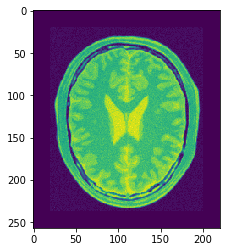

In [2]:
PixelType = itk.ctype('float')

fixedImage = itk.imread('data/BrainProtonDensitySliceBorder20.png', PixelType)
plt.imshow(itk.array_view_from_image(fixedImage))

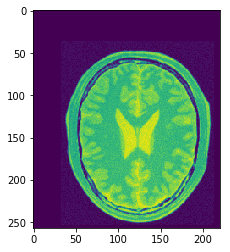

In [3]:
movingImage = itk.imread('data/BrainProtonDensitySliceShifted13x17y.png', PixelType)

plt.imshow(itk.array_view_from_image(movingImage))

In [4]:
Dimension = fixedImage.GetImageDimension()
FixedImageType = type(fixedImage)
MovingImageType = type(movingImage)

TransformType = itk.TranslationTransform[itk.D, Dimension]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=4,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200)

metric = itk.MeanSquaresImageToImageMetricv4[
    FixedImageType, MovingImageType].New()

In [5]:
registration = itk.ImageRegistrationMethodv4.New(FixedImage=fixMe,
        MovingImage=fixMe,
        Metric=fixMe,
        Optimizer=fixMe,
        InitialTransform=fixMe)

NameError: name 'fixMe' is not defined

In [11]:
# %load solutions/5_Registration_Exercise2Answer1.py

In [ ]:
movingInitialTransform = TransformType.New()
initialParameters = movingInitialTransform.GetParameters()
initialParameters[0] = 0
initialParameters[1] = 0
movingInitialTransform.SetParameters(initialParameters)
registration.SetMovingInitialTransform(movingInitialTransform)

identityTransform = TransformType.New()
identityTransform.SetIdentity()
registration.SetFixedInitialTransform(identityTransform)

registration.SetNumberOfLevels(1)
registration.SetSmoothingSigmasPerLevel([0])
registration.SetShrinkFactorsPerLevel([1])

registration.Update()

In [12]:
transform = registration.GetTransform()
finalParameters = transform.GetParameters()
translationAlongX = finalParameters.GetElement(0)
translationAlongY = finalParameters.GetElement(1)

numberOfIterations = optimizer.GetCurrentIteration()

bestValue = optimizer.GetValue()

print("Result = ")
print(" Translation X = " + str(translationAlongX))
print(" Translation Y = " + str(translationAlongY))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))

Result = 
 Translation X = 13.00123653240422
 Translation Y = 16.999943471681494
 Iterations    = 22
 Metric value  = 0.0006793961893802234


In [13]:
CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(movingInitialTransform)
outputCompositeTransform.AddTransform(registration.GetModifiableTransform())

In [ ]:
resampler = itk.ResampleImageFilter.New(Input=fixMe,
        Transform=fixMe,
        UseReferenceImage=True,
        ReferenceImage=fixMe)

In [ ]:
# %load solutions/5_Registration_Exercise2Answer2.py

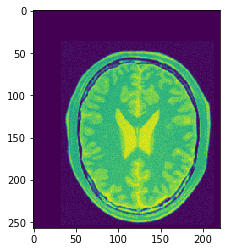

In [17]:
resampler.SetDefaultPixelValue(100)

OutputPixelType = itk.ctype('unsigned char')
OutputImageType = itk.Image[OutputPixelType, Dimension]

resampler.Update()

plt.imshow(itk.array_view_from_image(movingImage))

In [20]:
difference = itk.SubtractImageFilter.New(Input1=fixedImage,
        Input2=resampler)
resampler.SetDefaultPixelValue(1)

difference.Update()
view(difference.GetOutput())

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF2; proxy of <Swig Object of type 'itkIma…

In [21]:
resampler.SetTransform(identityTransform)
difference.Update()

view(difference.GetOutput())

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF2; proxy of <Swig Object of type 'itkIma…

## Exercise 3: Image similarity matching metrics

Examine the available [registration framework image similarity matching metrics](https://itk.org/Doxygen/html/classitk_1_1ImageToImageMetricv4.html).

- Can an alternative metric be used in the registration pipeline above?
- Which metrics should be used for multi-modality registration?

## Exercise 4: Multi-modality registration

![dzCBCT and dzTMJ](data/dzIntensities.png)


In [1]:
import numpy as np
import itk
from itkwidgets import view
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact

Pixel spacing: itkVectorD2 ([0.676923, 0.67692])


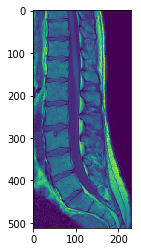

In [2]:
t1_image = itk.imread('data/DzZ_T1.nrrd', itk.F)
print("Pixel spacing:", t1_image.GetSpacing())
plt.imshow(itk.array_view_from_image(t1_image))

Pixel spacing: itkVectorD2 ([0.6, 0.6])
Direction matrix:
 [[-1.  0.]
 [ 0. -1.]]


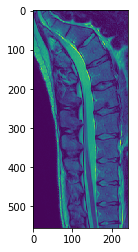

In [4]:
t2_image = itk.imread('data/DzZ_T2.nrrd', itk.F)
print("Pixel spacing:", t2_image.GetSpacing())
plt.imshow(itk.array_view_from_image(t2_image))

pyDirM=itk.GetArrayFromVnlMatrix(t2_image.GetDirection().GetVnlMatrix().as_matrix())
print("Direction matrix:\n", pyDirM)

In [5]:
# print(t2_image) # a lot of information about the image including direction matrix
view(t2_image) # metadata respected so image looks correct

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF2; proxy of <Swig Object of type 'itkIma…

In [6]:
T1ImageType = type(t1_image)
T2ImageType = type(t2_image)
assert T1ImageType==T2ImageType, "Images must have the same pixel type!"

TransformTypeR = itk.Rigid2DTransform[itk.D]
initialTransform = TransformTypeR.New()

MetricType = itk.MattesMutualInformationImageToImageMetricv4[
        T1ImageType, T2ImageType]
metric = MetricType.New()

scales = itk.OptimizerParameters[itk.D](initialTransform.GetNumberOfParameters())
translation_scale = 1.0 / 1000
scales.SetElement(0, 1.0)
scales.SetElement(1, translation_scale)
scales.SetElement(2, translation_scale)

#ScalesEstimatorType = itk.RegistrationParameterScalesFromPhysicalShift[MetricType]
#scalesEstimator = ScalesEstimatorType.New(Metric=metric)

optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        Scales=scales,
        #ScalesEstimator=scalesEstimator,
        #LearningRate=1.0,
        MinimumStepLength=0.001,
        # RelaxationFactor=0.8,
        NumberOfIterations=300)

registration = itk.ImageRegistrationMethodv4.New(FixedImage=t1_image,
        MovingImage=t2_image,
        Metric=metric,
        MetricSamplingPercentage=0.1, # 10%
        Optimizer=optimizer,
        InitialTransform=initialTransform)

initialParameters = initialTransform.GetParameters()

In [6]:
# fixMe: set initial parameters which result in converging registration
initialParameters[0] = fixMe # rotation in radians
initialParameters[1] = fixMe # x translation in millimeters
initialParameters[2] = fixMe # y translation in millimeters

In [8]:
# %load solutions/5_Registration_Exercise4Answer.py

In [9]:
initialTransform.SetParameters(initialParameters)

resampler = itk.ResampleImageFilter.New(Input=t2_image,
        Transform=initialTransform,
        UseReferenceImage=True,
        ReferenceImage=t1_image)
resampler.SetDefaultPixelValue(0)
resampler.Update()

# initial position of T2 image when resampled into T1 image's pixel grid
viewer1 = view(resampler.GetOutput(), ui_collapsed=True, annotations=False)
viewer2 = view(t1_image, ui_collapsed=True, annotations=False)
import ipywidgets as widgets
widgets.HBox([viewer1, viewer2])

In [10]:
registration.SetMovingInitialTransform(initialTransform)

Dimension = t1_image.GetImageDimension()
identityTransform = TransformTypeR.New()
identityTransform.SetIdentity()
registration.SetFixedInitialTransform(identityTransform)

registration.SetNumberOfLevels(1)
registration.SetSmoothingSigmasPerLevel([0])
registration.SetShrinkFactorsPerLevel([1])

try:
    registration.Update()
except RuntimeError as exc:
    print("Exception ocurred:\n", exc, "\n\n")
finally:
    print("Registration finished")
    
CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(registration.GetTransform())
outputCompositeTransform.AddTransform(initialTransform)
    
resamplerResult = itk.ResampleImageFilter.New(Input=t2_image,
        Transform=outputCompositeTransform,
        UseReferenceImage=True,
        ReferenceImage=t1_image)
resamplerResult.SetDefaultPixelValue(0)
resamplerResult.Update()
view(resamplerResult.GetOutput()) # final position of T2 image when resampled into T1 image's pixel grid

Registration finished


Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF2; proxy of <Swig Object of type 'itkIma…

In [11]:
transform = registration.GetTransform()
finalParameters = transform.GetParameters()
rotationInRadians = finalParameters.GetElement(0)
translationAlongX = finalParameters.GetElement(1)
translationAlongY = finalParameters.GetElement(2)
rotationInDegrees = rotationInRadians * 360 / 3.141592 # why 360?

numberOfIterations = optimizer.GetCurrentIteration()

bestValue = optimizer.GetValue()

print("Result = ")
print(" Rotation degr = " + str(rotationInDegrees))
print(" Translation X = " + str(translationAlongX))
print(" Translation Y = " + str(translationAlongY))
print(" Rotation rad. = " + str(rotationInRadians))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))

difference = itk.AddImageFilter.New(Input1=t1_image,
        Input2=resamplerResult)
difference.Update()
view(difference.GetOutput())

Result = 
 Rotation degr = -1.9551299701886167
 Translation X = -20.198147618496773
 Translation Y = 21.623765734246376
 Rotation rad. = -0.017061724092513324
 Iterations    = 81
 Metric value  = -0.9550125369219663


Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF2; proxy of <Swig Object of type 'itkIma…

## Enjoy ITK!